In [8]:
import pandas as pd
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import setup

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'
meteorological_data_path = data_path/'meteorological_data'
saving_path = data_path/'saved_files'

#### Functions

In [9]:
def read_manning(site):
    """
    Extracting Alistair's baseline flags for a given site

    Args:
    - site (str): Site code (e.g., MHD)

    Returns:
    - df (pandas.DataFrame): DataFrame with baseline flags as a binary variable
    """
    
    site_translator = {"MHD":"MH", "CGO":"CG", "GSN":"GS", "JFJ":"J1", "CMN":"M5", "THD":"TH", "ZEP":"ZE"}

    # Filtering so only including data relevant to the given site
    files = (data_path / "manning_baselines").glob(f"{site_translator[site]}*.txt")

    dfs = []

    # Looping through each of the files for the given site
    for file in files:

        # Read the data, skipping metadata, putting into pandas dataframe
        data = pd.read_csv(file, skiprows=6, delim_whitespace=True)

        # Setting the index of the dataframe to be the extracted datetime and naming it time
        data.index = pd.to_datetime(data['YY'].astype(str) + "-" + \
                                    data['MM'].astype(str) + "-" + \
                                    data['DD'].astype(str) + " " + \
                                    data['HH'].astype(str) + ":00:00")

        data.index.name = "time"
        
        # Adding the 'Ct' column to the previously created empty list
        dfs.append(data[["Ct"]])
    
    # Creating a dataframe from the list containing all the 'Ct' values
    df = pd.concat(dfs)

    df.sort_index(inplace=True)
    
    # Replace all values in Ct column less than 10 or greater than 20 with 0
    # not baseline values
    df.loc[(df['Ct'] < 10) | (df['Ct'] >= 20), 'Ct'] = 0

    # Replace all values between 10 and 19 with 1
    # baseline values
    df.loc[(df['Ct'] >= 10) & (df['Ct'] < 20), 'Ct'] = 1

    # Rename Ct column to "baseline"
    df.rename(columns={'Ct': 'baseline'}, inplace=True)

    return df

In [10]:
def balance_baselines(ds, minority_ratio): 
    """
    Balances the dataset by randomly undersampling non-baseline data points.

    Parameters:
    ds (xarray.Dataset): The dataset to be balanced.
    minority_ratio (float): The desired ratio of baseline (minority class) data points in the final dataset. 
                            For example, 0.4 means 40% of data points will be baseline.

    Returns:
    xarray.Dataset: The balanced dataset where the ratio of baseline to non-baseline data points is as specified by the `minority_ratio` argument.

    Raises:
    ValueError: If the counts of baseline and non-baseline values are not in the expected ratio (within a tolerance of 1%).

    """

    # counting number of baseline&non-baseline data points
    baseline_count = ds['baseline'].where(ds['baseline']==1).count()
    non_baseline_count = ds['baseline'].where(ds['baseline']==0).count()

    # calculating the minority class count (expected to be baseline)
    minority_count = int(min(baseline_count, non_baseline_count))

    # calculating the majority class count based on majority_ratio and minority_count
    majority_ratio = 1 - minority_ratio
    majority_count = int(minority_count * (majority_ratio/minority_ratio))

    # randomly undersampling non-baseline based on majority_count
    np.random.seed(42)
    undersampled_non_baseline = ds.where(ds['baseline'] == 0, drop=True)
    undersampled_non_baseline = undersampled_non_baseline.isel(time=np.random.choice(undersampled_non_baseline.dims['time'], majority_count, replace=False))

    # combining the the undersampled non-baseline with the baseline values
    balanced_ds = xr.merge([ds.where(ds['baseline'] == 1), undersampled_non_baseline])
    balanced_ds = balanced_ds.sortby('time')

    # checking balance
    new_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==1).count()
    new_non_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==0).count()

    # verifying that the ratio of baseline:non-baseline data points is as expected (within a tolerance of 1%)
    tolerance = 0.01
    upper_bound = (1+tolerance)*(majority_ratio/minority_ratio)
    lower_bound = (1-tolerance)*(majority_ratio/minority_ratio)

    if(lower_bound <= (new_non_baseline_count/new_baseline_count) <= upper_bound):
        return balanced_ds
    else:
        raise ValueError("The counts of baseline and non-baseline values are not in the expected ratio.")

#### Defining Site & Compound

In [11]:
site = setup.site
site_name = setup.site_dict[site]
compound = setup.compound
balance = True

print(f"Exploring {compound} at {site_name}.")

Exploring hfc-134a at Mace Head, Ireland.


##### Setting Up Variables

In [12]:
# extracting Manning's baseline flags for given site
df = read_manning(site)
# converting to xarray dataset
ds_flags = df.to_xarray()
# balancing the dataset
balanced_ds_flags = balance_baselines(ds_flags, 0.7)

In [13]:
# loading in the different variables
# 10m WIND (9 point system)
# U is the zonal wind component (positive is eastward)
# V is the meridional wind component (positive is northward)
ds_u = xr.open_mfdataset((meteorological_data_path/"ncep_9points").glob("*u*.nc")).sel(dict(site=site, level=10))
ds_v = xr.open_mfdataset((meteorological_data_path/"ncep_9points").glob("*v*.nc")).sel(dict(site=site, level=10))

# 3D WIND (pressure levels)

# SURFACE PRESSURE
ds_pres = xr.open_mfdataset((meteorological_data_path/"surface_pressure"/"extracted_data").glob("*.nc")).sel(dict(site=site))

# BOUNDARY LAYER HEIGHT


In [15]:
# Grab some AGAGE data
# original data
# ds_agage = xr.open_dataset(data_path / f"AGAGE/data-gcms-nc/AGAGE-GCMS-Medusa_{site}_{compound}.nc")
# reprocessed data
ds_agage = xr.open_dataset(next((data_path / "AGAGE" / "AGAGE-public-files" / compound).glob(f"*{site}_{compound}.nc")))                 

In [18]:
# Creating an xarray dataset with the u, v, surface pressure, mole fraction and baseline flags
# NON-BALANCED DATASET
data_ds = xr.combine_by_coords([ds_u.reindex_like(ds_agage, method="nearest"),
                    ds_v.reindex_like(ds_agage, method="nearest"),
                    ds_pres.reindex_like(ds_agage, method="nearest"),
                    ds_flags.baseline.reindex_like(ds_agage, method="nearest"),
                    ds_agage.mf],
                    combine_attrs="override", coords="minimal", compat="override")

# BALANCED DATASET
data_balanced_ds = xr.combine_by_coords([ds_u.reindex_like(ds_agage, method="nearest"),
                    ds_v.reindex_like(ds_agage, method="nearest"),
                    ds_pres.reindex_like(ds_agage, method="nearest"),
                    balanced_ds_flags.baseline.reindex_like(ds_agage, method="nearest"),
                    ds_agage.mf],
                    combine_attrs="override", coords="minimal", compat="override")

# removing associated variable values to the baseline values removed in balancing (uses a mask)
data_balanced_ds = data_balanced_ds.where(~np.isnan(data_balanced_ds['baseline']), drop=True)

# saving these datasets for use in model evaluation/benchmark analysis
data_ds.to_netcdf(saving_path/'data_ds.nc')
data_balanced_ds.to_netcdf(saving_path/'data_balanced_ds.nc')

Original mean: 74.036, Balanced mean: 72.563. Percentage difference: 1.99%
Original std: 34.172, Balanced std: 34.103. Percentage difference: 0.20%


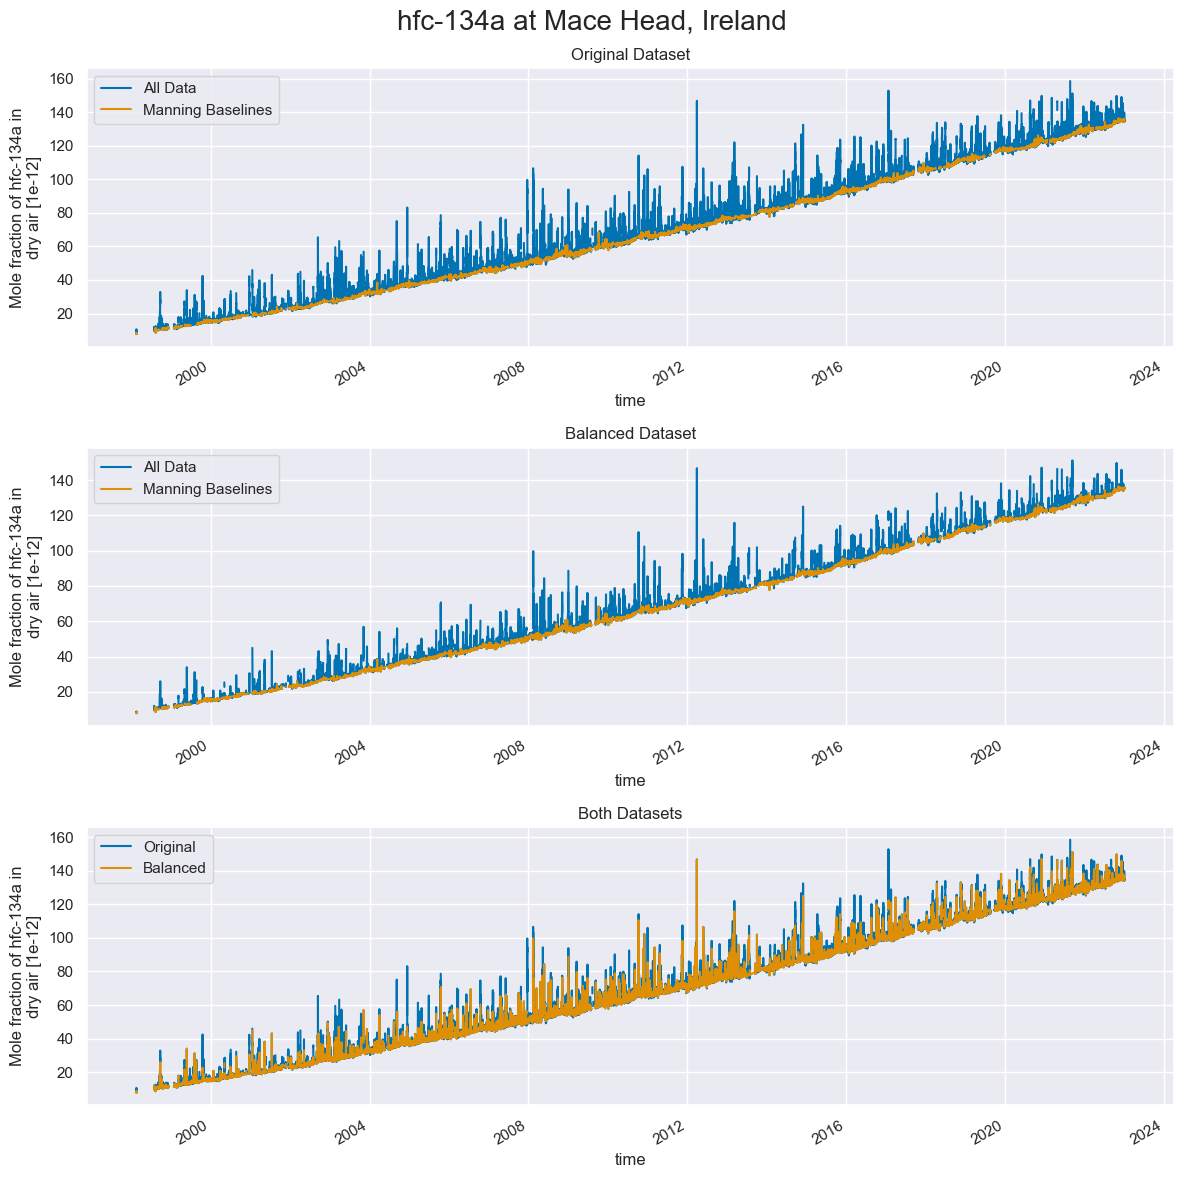

In [23]:
# comparing the mole fraction time series for the original and balanced datasets
# calculating statistics
original_mf = data_ds.mf.values
original_mf = original_mf[~np.isnan(original_mf)]
balanced_mf = data_balanced_ds.mf.values
balanced_mf = balanced_mf[~np.isnan(balanced_mf)]

original_mean = original_mf.mean()
original_std = original_mf.std()
balanced_mean = balanced_mf.mean()
balanced_std = balanced_mf.std()

print(f"Original mean: {original_mean:.3f}, Balanced mean: {balanced_mean:.3f}. Percentage difference: {(abs(original_mean-balanced_mean)/original_mean)*100:.2f}%"
      f"\nOriginal std: {original_std:.3f}, Balanced std: {balanced_std:.3f}. Percentage difference: {(abs(original_std-balanced_std)/original_std)*100:.2f}%")

# plotting
fig, axs = plt.subplots(3,1, figsize=(12,12))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

data_ds.mf.plot(ax=axs[0], label="All Data")
data_ds.where(data_ds.baseline == 1, drop=True).mf.plot(ax=axs[0], label="Manning Baselines")
axs[0].set_title("Original Dataset")
axs[0].legend()

data_balanced_ds.mf.plot(ax=axs[1], label="All Data")
data_balanced_ds.where(data_balanced_ds.baseline == 1, drop=True).mf.plot(ax=axs[1], label="Manning Baselines")
axs[1].set_title("Balanced Dataset")
axs[1].legend()

data_ds.mf.plot(ax=axs[2], label="Original")
data_balanced_ds.mf.plot(ax=axs[2], label="Balanced")
axs[2].set_title("Both Datasets")
axs[2].legend()

fig.suptitle(f"{compound} at {site_name}", fontsize=20)
fig.set_tight_layout(True)

In [20]:
# converting xarray dataset to pandas dataframe - UNBALANCED
data_df = pd.DataFrame({"flag": data_ds.baseline.values}, index=data_ds.time.values)

# adding the other variables to the dataframe
# 10m WIND (9 point system)
for point in data_ds.points.values:
    data_df[f"u_{point}"] = data_ds.uwnd.sel(points=point).values
    data_df[f"v_{point}"] = data_ds.vwnd.sel(points=point).values

# 3D WIND (pressure levels)

# SURFACE PRESSURE
data_df['pres'] = data_ds.pres.values
    
# BOUNDARY LAYER HEIGHT

# Adding time of day & day of year as features
data_df["time_of_day"] = data_df.index.hour
data_df["day_of_year"] = data_df.index.dayofyear


# converting xarray dataset to pandas dataframe - BALANCED
data_balanced_df = pd.DataFrame({"flag": data_balanced_ds.baseline.values}, index=data_balanced_ds.time.values)

for point in data_balanced_ds.points.values:
    data_balanced_df[f"u_{point}"] = data_balanced_ds.uwnd.sel(points=point).values
    data_balanced_df[f"v_{point}"] = data_balanced_ds.vwnd.sel(points=point).values

data_balanced_df['pres'] = data_balanced_ds.pres.values

data_balanced_df["time_of_day"] = data_balanced_df.index.hour
data_balanced_df["day_of_year"] = data_balanced_df.index.dayofyear

In [21]:
# ready for model; saving to csv
# NON BALANCED
# data_df.index.name = 'time'
# data_df.to_csv(saving_path/'for_model.csv')

# BALANCED
data_balanced_df.index.name = 'time'
data_balanced_df.to_csv(saving_path/'for_model.csv', index=True)

In [22]:
model_df = pd.read_csv(saving_path/'for_model.csv', index_col='time')
model_df.head()

,flag,u_0,v_0,u_1,v_1,u_2,v_2,u_3,v_3,u_4,...,v_5,u_6,v_6,u_7,v_7,u_8,v_8,pres,time_of_day,day_of_year
time,,,,,,,,,,,,,,,,,,,,,
1998-01-01 07:42:00,1.0,10.509994,18.309998,-8.169998,29.640000,-10.880005,29.130005,0.459991,26.789993,8.149994,...,17.599990,22.279999,8.080002,26.000000,5.229996,6.729996,13.580002,98900.0,7,1
1998-01-01 11:43:00,1.0,21.039993,0.720001,9.169998,16.830002,-6.229996,21.959991,15.149994,15.089996,20.440002,...,0.889999,21.959991,1.720001,21.380005,2.949997,17.099990,9.869995,97320.0,11,1
1998-01-01 15:44:00,0.0,8.869995,7.809998,14.309998,12.679993,8.660004,13.250000,11.720001,6.319992,17.679993,...,6.709992,25.630005,3.389999,22.690002,-0.059998,16.880005,6.830002,97610.0,15,1
1998-01-01 23:47:00,0.0,14.169998,0.350006,8.770004,14.740006,5.750000,16.940002,8.550003,7.099991,22.500000,...,-1.850006,23.509995,-1.440002,23.789993,-1.270004,16.470001,2.250000,97240.0,23,1
1998-01-02 07:50:00,1.0,15.589996,0.720001,11.279999,11.910004,3.139999,17.720001,12.690002,-2.740006,20.699997,...,-2.600006,16.110000,1.389999,21.819992,0.580002,21.550003,-0.779999,97460.0,7,2
